<div style="width: 60%; clear: both;">
    <div style="float: left; width: 40%;">
       <img src="https://universidadeuropea.com/resources/media/images/universidad-europea-logo_poc9mEM.original.png", align="left">
    </div>
</div>
<div style="float: right; width: 60%;">
<p style="margin-left:0; margin-right:0; text-align:right"><span style="font-size:22px"><strong>MASTER UNIVERSITARIO EN ANALISIS DE DATOS MASIVOS (BIG DATA)</strong></span></p>
<p style="margin-left:0; margin-right:0; text-align:right"><span style="font-size:22px"><strong>Trabajo Final de Máster</strong></span></p>
<p style="margin-left:0; margin-right:0; text-align:right"><span style="font-size:22px">CLASIFICACIÓN DE NOTICIAS MEDIANTE EL USO DE MODELOS BASADOS EN TRANSFORMERS</span></p>
<p style="margin-left:0; margin-right:0; text-align:right">
  <span style="font-size:18px; display:inline-block;">GERARD MART&Iacute;NEZ CA&Ntilde;ETE</span>
  <a href="https://www.linkedin.com/in/gmcanete/" target="_blank" style="display:inline-block;">
    <img src="https://cdn-icons-png.flaticon.com/512/174/174857.png" alt="Logo de LinkedIn" width="20" style="vertical-align: middle;">
  </a>
</p>
</div>

# Test GPT2 preentrenado

## Preparación del entorno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy pandas scikit-learn torch transformers seaborn matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00


## Test

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize
from transformers import GPT2Tokenizer,GPT2Config, GPT2ForSequenceClassification, TextClassificationPipeline
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/9categ/9cat_test_dataset.csv')
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,encoded_label
0,El que llegireu a continuació és una d’aquelle...,ciencia,0
1,Uno de los principales problemas que provocan ...,ciencia,0
2,La primavera de este año deja dos eclipses. El...,ciencia,0
3,En un discret racó del laboratori d’oncologia ...,ciencia,0
4,"La lluna, l’únic satèl·lit natural de la Terra...",ciencia,0


In [ ]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model_config = GPT2Config.from_pretrained(model_name, num_labels=len(df['encoded_label'].unique()))
model = GPT2ForSequenceClassification.from_pretrained(model_name, config=model_config)

pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': pad_token})
model.resize_token_embeddings(len(tokenizer))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

In [ ]:
def predict_label(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_label_id = torch.argmax(probabilities, dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
    return predicted_label, probabilities.detach().cpu().numpy()


In [8]:
tqdm.pandas()
results = df['text'].progress_apply(lambda x: predict_label(x))
df['predicted_label'] = results.progress_apply(lambda x: x[0])
probabilities = results.progress_apply(lambda x: x[1]).tolist()
probabilities_array = np.array(probabilities).squeeze(axis=1)

100%|██████████| 1800/1800 [00:00<00:00, 238380.45it/s]


## Resultados

In [9]:
accuracy = accuracy_score(df['label'], df['predicted_label'])
precision = precision_score(df['label'], df['predicted_label'], average='weighted')
recall = recall_score(df['label'], df['predicted_label'], average='weighted')
f1 = f1_score(df['label'], df['predicted_label'], average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.1111111111111111
Precision: 0.05814926983795451
Recall: 0.1111111111111111
F1 Score: 0.03088541682050183


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
df.to_csv('/content/drive/MyDrive/9categ/9cat_test_dataset_with_predictions_gpt2_untrained.csv', index=False)

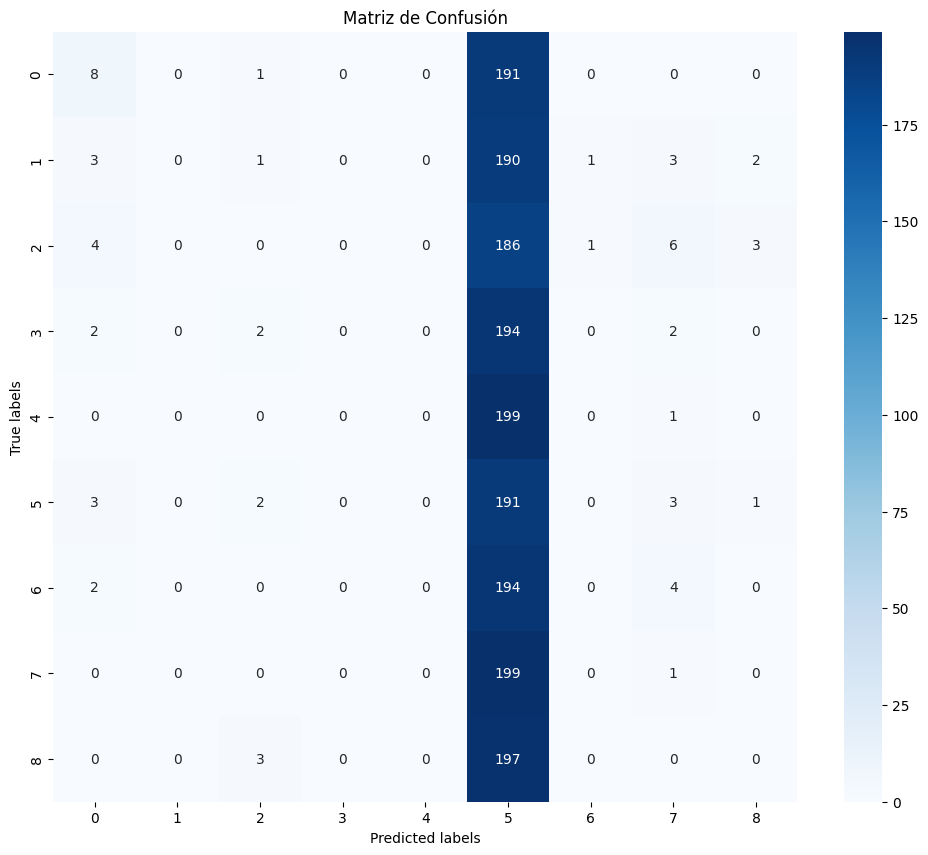

In [11]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(df["label"], df['predicted_label'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Matriz de Confusión")
plt.show()